This notebook dicsusses the usage of the "cold plasma dispersion relation" given by the funciton stix().
A dispersion relation is a relation between the frequency and the wavelength of a wave. In magnentised plasmas due to the magnetic field
this relation becomes very complicated. To make the problem tractable, the so-called cold plasma approximation is used. Within this approximation, the dispersion relation is given by a polynomial equation of the 4th degree:

$N^4 A(\omega_{pe}, \omega_{ce}, \theta) + N^2 B(\omega_{pe}, \omega_{ce}, \theta) + C(\omega_{pe}, \omega_{ce}) = 0$,
where $N=ck/\omega$ is the refractive index. This equation has four roots, which account for two propagating modes in forward and backward directions.
The plasma properties and the angle propgation angle $\theta$ enter through the coefficients $A, B, C$  

In [1]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants.si import c

from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency
from plasmapy.particles import Particle

In [2]:
help(stix)

Help on function stix in module plasmapy.dispersion.analytical.stix_:

stix(B: Unit("T"), w: Unit("rad / s"), ions: plasmapy.particles.particle_class.Particle, n_i: Unit("1 / m3"), theta: Unit("rad"))
    Calculate the cold plasma dispersion function presented by
    :cite:t:`stix:1992`, and discussed by :cite:t:`bellan:2012`.
    This is an analytical solution of equation 8 in
    :cite:t:`bellan:2012`.  See the **Notes** section below for
    additional details.
    
    Parameters
    ----------
    B : `~astropy.units.Quantity`
        The magnetic field magnitude in units convertible to T.
    
    w : `~astropy.units.Quantity`, single valued or 1-D array
        Wavefrequency in units convertible to rad/s.  Either singled
        valued or 1-D array of length :math:`N`.
    
    ions: a single or `list` of :term:`particle-like` object(s)
        A list or single instance of :term:`particle-like` objects
        representing the ion species (e.g., ``"p"`` for protons,
        ``"D

Let's the refractive index for three angles and different plasma densities

In [43]:
N = 200
theta = np.array([np.pi/2, np.pi/6, np.pi/8])*u.rad
n_i = np.linspace(1e10,3e17,N)*u.m**-3
w_pe = plasma_frequency(n_i, Particle('e-'))
w_ce = gyrofrequency(B, Particle('e-'))
w = 2*np.pi*2.45e9*u.rad/u.s
Y = w_ce/w
print('Y',Y)
theta_opt = np.arccos(np.sqrt(Y/(1+Y)))
theta = np.array([np.pi/2,theta_opt])*u.rad

ions = Particle('p+')

B = 0.06*u.T
k_arr = np.zeros((3,4,N),dtype=np.complex128)
for i in range(0,N):
    params = {'theta':theta,'w':w, 'ions':ions, 'n_i':n_i[i], 'B':B} 
    k = stix(**params)
    k_arr[:,:,i] = k.value

Y 0.6855303642204009


TypeError: only dimensionless scalar quantities can be converted to Python scalars

Y 0.6855303642204009
10552920064.632978 rad / s


/home/kirill/PlasmaPy/.venv/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


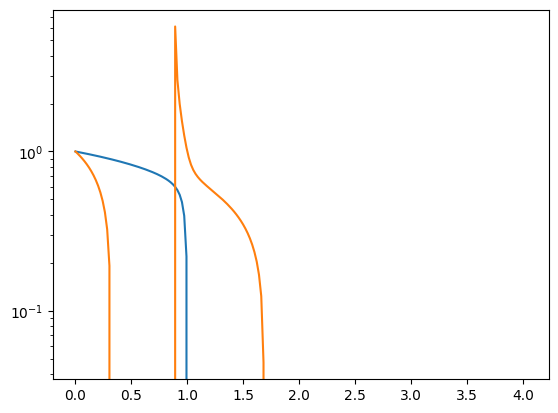

In [36]:

X = (w_pe/w)**2
plt.plot(X,k_arr[2,0,:]*c/w)
plt.plot(X,k_arr[2,2,:]*c/w)
plt.yscale('log')
print(w_ce)

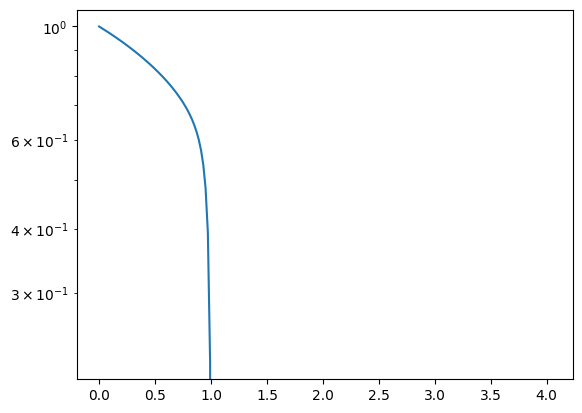

In [5]:
plt.plot(X,(k_arr[2,0,:]*c/w).real)

plt.yscale('log')